# Introduction

This is a basic exploratory data analysis of the ANZ customer transaction data provided by ANZ Bank and InsideSherpa. We'll be looking into:

1. The data and its features.
2. Some bit of data cleaning and modification
3. Outlier detection
4. Data segmentation and Transaction and Spending Volume charts
5. Insights from location data

The Tableau version of this report can be found below:
https://public.tableau.com/profile/john.osorio#!/vizhome/InsideSherpa_ANZ_EDA/InsideSherpaANZCustomerInsights

# 1. The data and its features

First let's import the relevant packages and libraries

In [1]:
# For opening the dataset
import pandas as pd
import numpy as np

# Useful for modifying the date and time 
import datetime

# Some basic regular expression for isolating the customer state from the address
import regex as re

# For plotting our charts
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Useful for geocoding the lattitude and longitude data
import geopandas as gpd
from cartopy import crs as ccrs
from geopy.geocoders import Nominatim

Open the Excel file and load it into a dataframe

In [2]:
df = pd.read_excel(r'C:\Users\john.osorio\Desktop\BLACK CAT\InsideSherpa\ANZ synthesised transaction dataset.xlsx')

A quick peek at the data

In [3]:
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


Here are the column information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
status               12043 non-null object
card_present_flag    7717 non-null float64
bpay_biller_code     885 non-null object
account              12043 non-null object
currency             12043 non-null object
long_lat             12043 non-null object
txn_description      12043 non-null object
merchant_id          7717 non-null object
merchant_code        883 non-null float64
first_name           12043 non-null object
balance              12043 non-null float64
date                 12043 non-null datetime64[ns]
gender               12043 non-null object
age                  12043 non-null int64
merchant_suburb      7717 non-null object
merchant_state       7717 non-null object
extraction           12043 non-null object
amount               12043 non-null float64
transaction_id       12043 non-null object
country              12043 non-null object
customer_id          12043 n

# Note: For now I won't provide an analysis on the null values and how each features relate to each other, that would be covered in a separate workbook.

# 2. Some bit of data cleaning and modification

I've done a thorough feature analysis in another workbook and I don't need to clean the data yet although I discovered that there is no data during August 16 and a customer with non-existent longitude and lattitude data but more on that later. For now let's modify the date and time of the transaction. 

In [5]:
#Create a helper function that extracts and returns the time from the extraction feature

def get_time(extraction):
    pattern = 'T(\S+:..)'
    timestring = re.findall(pattern, extraction)
    hour = timestring[0][0:2]
    minute = timestring[0][3:5]
    second = timestring[0][6:]
    
    return hour, minute, second

Sample looks like

In [6]:
get_time(df.extraction[0])

('01', '01', '15')

In [7]:
#Create a helper function that extracts and returns the year, month and day from the date

def get_date(date):
    month = date.strftime('%b')
    day = date.strftime('%d')
    year = date.strftime('%Y')
    return month, day, year

Sample looks like

In [8]:
print(get_date(df.date[0]))

('Aug', '01', '2018')


# Create a new dataframe containing the separated date and time and concatenante them to the existing dataframe

In [9]:
date_separated = [get_date(d) for d in df.date]

In [10]:
date_separated_df = pd.DataFrame(date_separated, columns = ['month', 'day', 'year'])

In [11]:
df = pd.concat([df, date_separated_df], axis = 1)

In [12]:
time_separated = [get_time(t) for t in df.extraction]

In [13]:
time_separated_df = pd.DataFrame(time_separated, columns=['hour', 'minute', 'seconds'])

In [14]:
df = pd.concat([df, time_separated_df], axis = 1)

The updated dataframe will now look like this

In [15]:
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,country,customer_id,merchant_long_lat,movement,month,day,year,hour,minute,seconds
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,Australia,CUS-2487424745,153.38 -27.99,debit,Aug,01,2018,01,01,15
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,Australia,CUS-2487424745,151.21 -33.87,debit,Aug,01,2018,01,13,45
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,Australia,CUS-2142601169,151.21 -33.87,debit,Aug,01,2018,01,26,15
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,Australia,CUS-1614226872,153.05 -26.68,debit,Aug,01,2018,01,38,45
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,Australia,CUS-2487424745,153.44 -28.06,debit,Aug,01,2018,01,51,15


# 3. Outlier detection

Plot the amount spent for all three months

[Text(0.5,1,'October')]

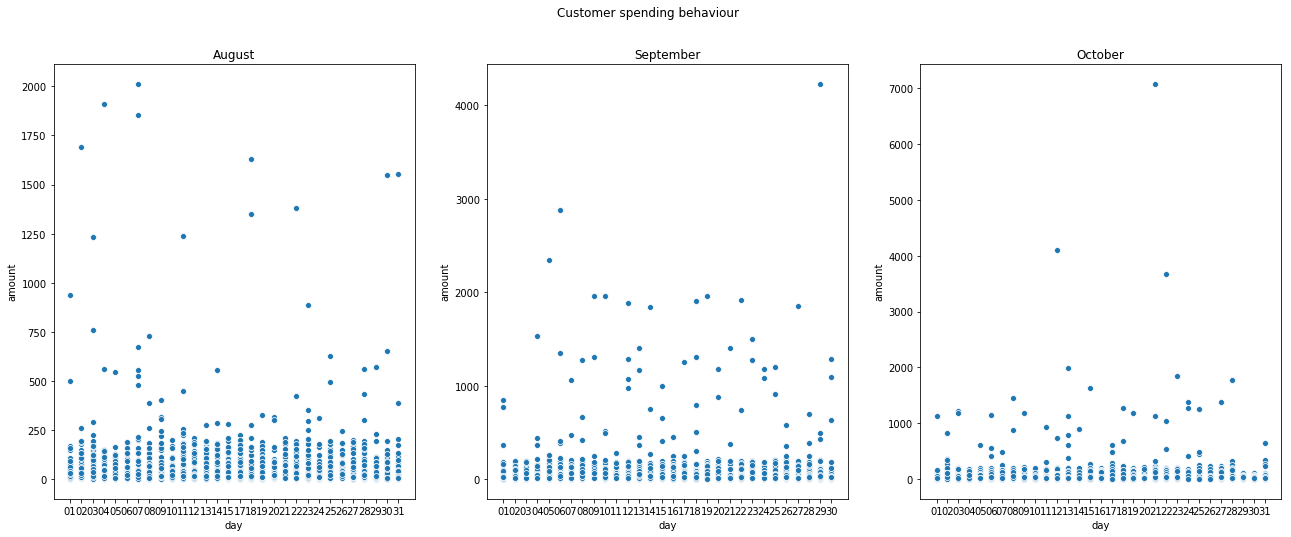

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8))
fig.suptitle('Customer spending behaviour')


# Spending data for August
x_aug = df[(df.month == 'Aug') & (df.txn_description != 'PAY/SALARY')].day
y_aug = df[(df.month == 'Aug') & (df.txn_description != 'PAY/SALARY')].amount

# Spending data for September
x_sep = df[(df.month == 'Sep') & (df.txn_description != 'PAY/SALARY')].day
y_sep = df[(df.month == 'Sep') & (df.txn_description != 'PAY/SALARY')].amount

# Spending data for October
x_oct = df[(df.month == 'Oct') & (df.txn_description != 'PAY/SALARY')].day
y_oct = df[(df.month == 'Oct') & (df.txn_description != 'PAY/SALARY')].amount

sns.scatterplot(x_aug, y_aug, ax=axes[0])
sns.scatterplot(x_sep, y_sep, ax=axes[1])
sns.scatterplot(x_oct, y_oct, ax=axes[2])

axes[0].set(title='August')
axes[1].set(title='September')
axes[2].set(title='October')


So we can see that there have been single SPENDING transactions where the customer spent around 2,000 to 7,000 AUD. PAY/SALARY transaction types don't count as outliers in this case since its money coming in 

# We can use the Z-score to determine which outliers in the customer's spending habits

In [17]:
# Create a helper function to return a list of all outliers in the data

def Z_detect_outliers(spending_amount):
    
    threshold = 3
    outliers = []
    mean = np.mean(spending_amount)
    std = np.std(spending_amount)
    
    for n in spending_amount:
        z_score = (n - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(n)
    
    return outliers

In [18]:
# We must not include data described as PAY/SALARY and with movement that says 'debit'
spending_amount = df[(df.txn_description != 'PAY/SALARY') & (df.movement == 'debit')].amount

In [19]:
outliers = Z_detect_outliers(spending_amount)

In [20]:
print('We have', len(outliers), 'outliers')
print('Any transaction with an amount above', min(outliers), 'AUD are outliers')

We have 106 outliers
Any transaction with an amount above 523.9 AUD are outliers


# Let's now replot the amounts without the outliers

[Text(0.5,1,'October')]

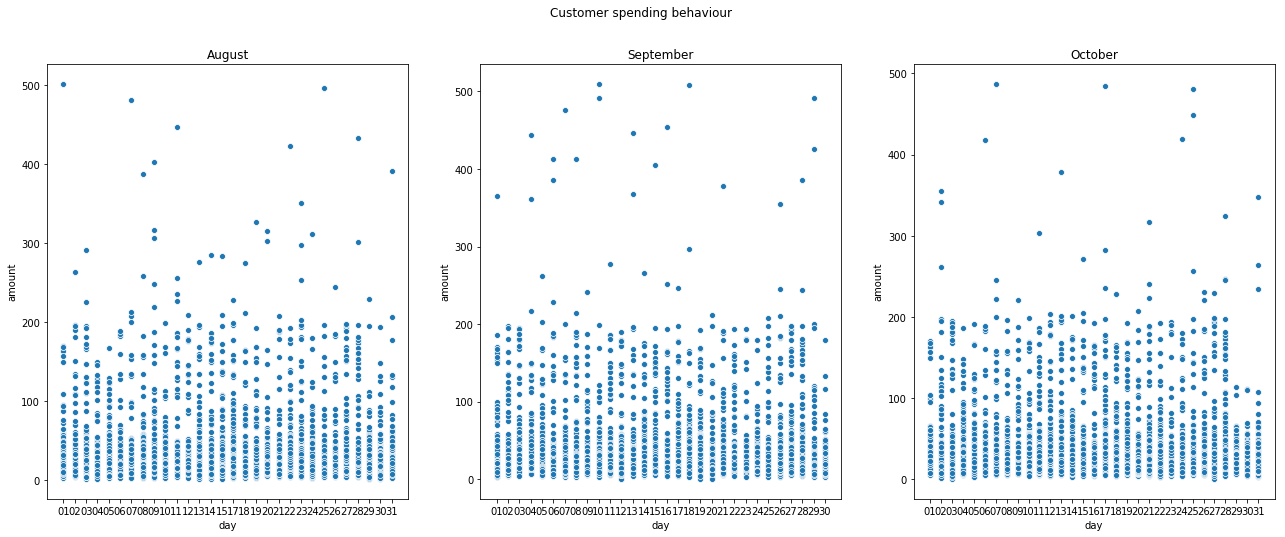

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(22, 8))
fig.suptitle('Customer spending behaviour')


# Spending data for August
x_aug = df[(df.month == 'Aug') & (df.txn_description != 'PAY/SALARY') & (df.amount < 523.9)].day
y_aug = df[(df.month == 'Aug') & (df.txn_description != 'PAY/SALARY') & (df.amount < 523.9)].amount

# Spending data for September
x_sep = df[(df.month == 'Sep') & (df.txn_description != 'PAY/SALARY') & (df.amount < 523.9)].day
y_sep = df[(df.month == 'Sep') & (df.txn_description != 'PAY/SALARY') & (df.amount < 523.9)].amount

# Spending data for October
x_oct = df[(df.month == 'Oct') & (df.txn_description != 'PAY/SALARY') & (df.amount < 523.9)].day
y_oct = df[(df.month == 'Oct') & (df.txn_description != 'PAY/SALARY') & (df.amount < 523.9)].amount

sns.scatterplot(x_aug, y_aug, ax=axes[0])
sns.scatterplot(x_sep, y_sep, ax=axes[1])
sns.scatterplot(x_oct, y_oct, ax=axes[2])

axes[0].set(title='August')
axes[1].set(title='September')
axes[2].set(title='October')

So that's looking better now

# 4. Data segmentation and Transaction and Spending Volume charts

Let's create a new dataframe first and remove all outliers

In [22]:
df_no = df[(df.amount < 523.9) | (df.txn_description == 'PAY/SALARY')]

In [23]:
df_no.txn_description.value_counts()

SALES-POS     3910
POS           3756
PAYMENT       2562
PAY/SALARY     883
INTER BANK     727
PHONE BANK      99
Name: txn_description, dtype: int64

Let's first get all the transaction volume for the given day per month

In [24]:
aug_transaction_volume = df_no[df_no.month == 'Aug'].day.value_counts().sort_index()
sep_transaction_volume = df_no[df_no.month == 'Sep'].day.value_counts().sort_index()
oct_transaction_volume = df_no[df_no.month == 'Oct'].day.value_counts().sort_index()

In [25]:
total_daily_txn = aug_transaction_volume.append(sep_transaction_volume, ignore_index=False).append(oct_transaction_volume, ignore_index=False)

In [26]:
len(total_daily_txn)

91

Now this may seem weird since we have 91 days for all three months when both August and October have 31 days each and September has 30, I had a closer look at August and it has no data on the 16th

In [27]:
df_no[(df_no.month == 'Aug') & (df_no.day == '16')]

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,country,customer_id,merchant_long_lat,movement,month,day,year,hour,minute,seconds


Let's convert the day feature to int

In [28]:
day = [int(x) for x in df_no.day]
df_no.drop('day', axis=1, inplace=True)
df_no['day'] = day

C:\Users\john.osorio\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\john.osorio\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
# Segment the dataframe into their weekly values grouped by month
# A typical week would be from Monday to Sunday

#August starts on a Wendesday
aug_week1 = df_no[(df_no.month == 'Aug') & (df_no.day >= 1) & (df_no.day <= 5)]
aug_week2 = df_no[(df_no.month == 'Aug') & (df_no.day >= 6) & (df_no.day <= 12)]
aug_week3 = df_no[(df_no.month =='Aug') & (df_no.day >= 13) & (df_no.day <= 19)]
aug_week4 = df_no[(df_no.month == 'Aug') & (df_no.day >= 20) & (df_no.day <= 26)]
aug_week5 = df_no[(df_no.month == 'Aug') & (df_no.day >= 27) & (df_no.day <= 31)]

#September starts on a Saturday
sep_week1 = df_no[(df_no.month == 'Sep') & (df_no.day >= 1) & (df_no.day <= 2)]
sep_week2 = df_no[(df_no.month == 'Sep') & (df_no.day >= 3) & (df_no.day <= 9)]
sep_week3 = df_no[(df_no.month == 'Sep') & (df_no.day >= 10) & (df_no.day <= 16)]
sep_week4 = df_no[(df_no.month == 'Sep') & (df_no.day >= 17) & (df_no.day <= 23)]
sep_week5 = df_no[(df_no.month == 'Sep') & (df_no.day >= 24) & (df_no.day <= 30)]

#October starts on a Monday
oct_week1 = df_no[(df_no.month == 'Oct') & (df_no.day >= 1) & (df_no.day <= 7)]
oct_week2 = df_no[(df_no.month == 'Oct') & (df_no.day >= 8) & (df_no.day <= 14)]
oct_week3 = df_no[(df_no.month == 'Oct') & (df_no.day >= 15) & (df_no.day <= 21)]
oct_week4 = df_no[(df_no.month == 'Oct') & (df_no.day >= 22) & (df_no.day <= 28)]
oct_week5 = df_no[(df_no.month == 'Oct') & (df_no.day >= 29) & (df_no.day <= 31)]


In [126]:
sep_week1.txn_description.value_counts()

SALES-POS     102
POS           101
PAYMENT        46
INTER BANK     14
PHONE BANK      1
Name: txn_description, dtype: int64

In [31]:
aug_week1.txn_description.count()

657

In [166]:

aug_txn_weekly_df = pd.DataFrame(columns = ['SALES-POS', 'POS', 'PAYMENT', 'PAY/SALARY', 'INTER-BANK', 'PHONE-BANK'],
                                data=[aug_week1.txn_description.value_counts().values.reshape(1, 6)[0], 
                                     aug_week2.txn_description.value_counts().values.reshape(1, 6)[0],
                                     aug_week3.txn_description.value_counts().values.reshape(1, 6)[0],
                                     aug_week4.txn_description.value_counts().values.reshape(1, 6)[0],
                                     aug_week5.txn_description.value_counts().values.reshape(1, 6)[0]],
                                index = ['week1', 'week2', 'week3', 'week4', 'week5'])

sep_txn_weekly_df = pd.DataFrame(columns = ['SALES-POS', 'POS', 'PAYMENT', 'PAY/SALARY', 'INTER-BANK', 'PHONE-BANK'],
                                data=[np.array([102, 101, 46, 0, 14, 1]),
                                     sep_week2.txn_description.value_counts().values.reshape(1, 6)[0],
                                     sep_week3.txn_description.value_counts().values.reshape(1, 6)[0],
                                     sep_week4.txn_description.value_counts().values.reshape(1, 6)[0],
                                     sep_week5.txn_description.value_counts().values.reshape(1, 6)[0]],
                                index = ['week1', 'week2', 'week3', 'week4', 'week5'])

oct_txn_weekly_df = pd.DataFrame(columns = ['SALES-POS', 'POS', 'PAYMENT', 'PAY/SALARY', 'INTER-BANK', 'PHONE-BANK'],
                                data=[oct_week1.txn_description.value_counts().values.reshape(1, 6)[0], 
                                     oct_week2.txn_description.value_counts().values.reshape(1, 6)[0],
                                     oct_week3.txn_description.value_counts().values.reshape(1, 6)[0],
                                     oct_week4.txn_description.value_counts().values.reshape(1, 6)[0],
                                     oct_week5.txn_description.value_counts().values.reshape(1, 6)[0]],
                                index = ['week1', 'week2', 'week3', 'week4', 'week5'])

# Weekly Transaction Volume

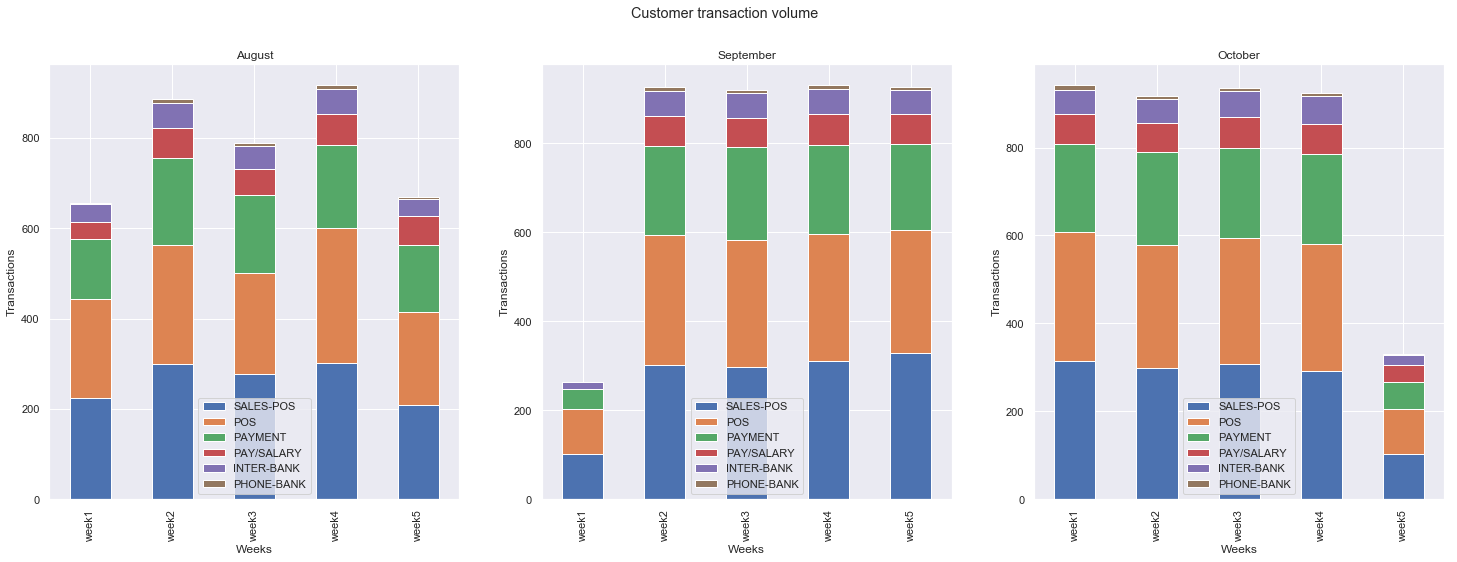

In [191]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Customer transaction volume')

aug_txn_weekly_df.plot(kind='bar', stacked=True, ax = axes[0])

sep_txn_weekly_df.plot(kind='bar', stacked=True, ax = axes[1])

oct_txn_weekly_df.plot(kind='bar', stacked=True, ax = axes[2])

axes[0].set(xlabel='Weeks', ylabel='Transactions', title = 'August')
axes[1].set(xlabel='Weeks', ylabel='Transactions', title = 'September')
axes[2].set(xlabel='Weeks', ylabel='Transactions', title = 'October')

axes[0].legend(loc='lower center')
axes[1].legend(loc='lower center')
axes[2].legend(loc='lower center')
plt.show()

# The chart above shows that POS type transactions dominate the weekly transaction volume during the 3 months.

# Monthly Transaction Volume

In [178]:
txn_monthly_df = pd.DataFrame(columns = ['SALES-POS', 'POS', 'PAYMENT', 'PAY/SALARY', 'INTER-BANK', 'PHONE-BANK'],
                                data=[df_no[df_no.month == 'Aug'].txn_description.value_counts().values.reshape(1, 6)[0],
                                     df_no[df_no.month == 'Sep'].txn_description.value_counts().values.reshape(1, 6)[0],
                                     df_no[df_no.month == 'Oct'].txn_description.value_counts().values.reshape(1, 6)[0]],
                                index = ['August', 'September', 'October'])

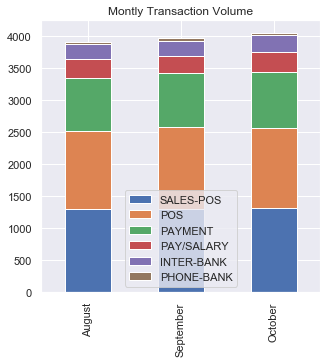

In [187]:
txn_monthly_df.plot(kind='bar', stacked=True, figsize=(5, 5), title='Montly Transaction Volume')
plt.legend(loc='lower center')

# Hourly Transaction Volume

Present an hourly stacked bar chart showing the different kinds of transaction types based on their frequency grouped by month

In [257]:
aug_hourly_txn = df_no[df_no.month == 'Aug'].groupby('hour').txn_description.value_counts()
sep_hourly_txn = df_no[df_no.month == 'Sep'].groupby('hour').txn_description.value_counts()
oct_hourly_txn = df_no[df_no.month == 'Oct'].groupby('hour').txn_description.value_counts()

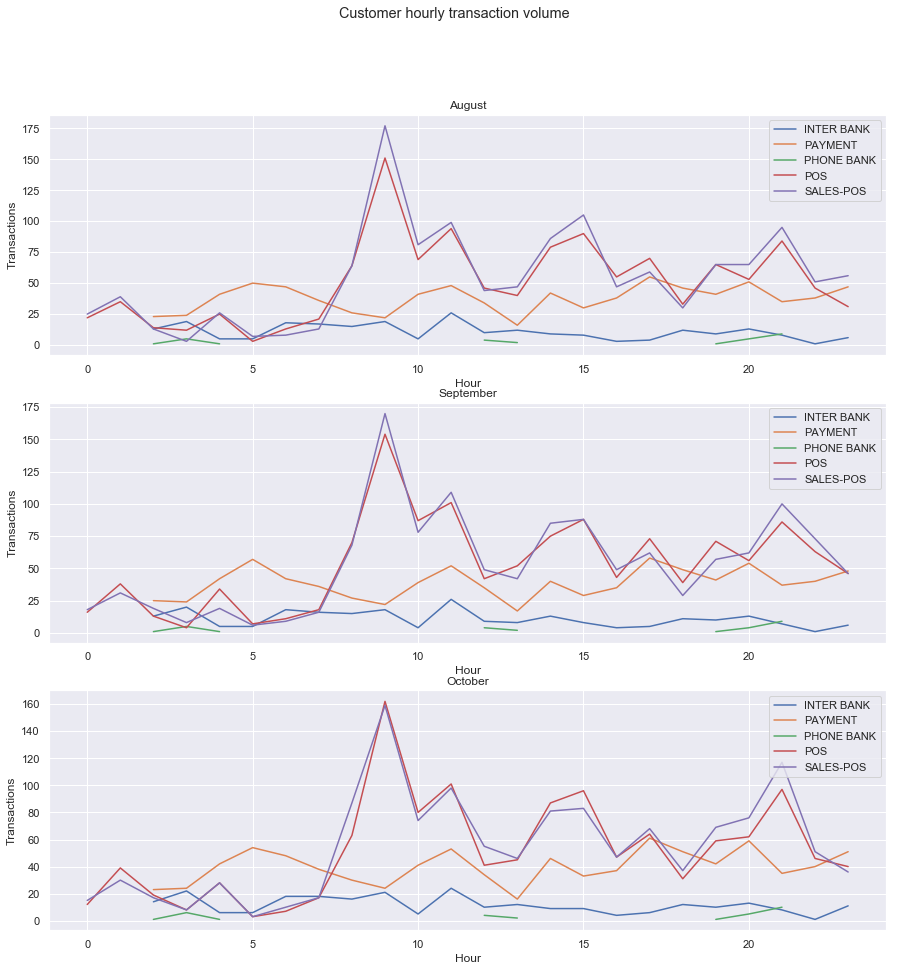

In [269]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle('Customer hourly transaction volume')

aug_hourly_txn.unstack().plot(kind = 'line', ax = axes[0])

sep_hourly_txn.unstack().plot(kind = 'line', ax = axes[1])

oct_hourly_txn.unstack().plot(kind = 'line', ax = axes[2])

axes[0].set(xlabel='Hour', ylabel='Transactions', title = 'August')
axes[1].set(xlabel='Hour', ylabel='Transactions', title = 'September')
axes[2].set(xlabel='Hour', ylabel='Transactions', title = 'October')

axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
plt.show()

# The major bulk of the transactions happen just slightly before 10 am and it's mostly POS based transactions, it picks up again just after 10 pm. Inter-bank transactions remain steady throughout the day

# Weekly Spending Volume

In [198]:
aug_week1[aug_week1.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum()

txn_description
INTER BANK    2518.00
PAYMENT       7984.00
PHONE BANK     217.00
POS           7015.80
SALES-POS     6487.84
Name: amount, dtype: float64

In [199]:
aug_week1[aug_week1.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0]

array([[2518.  , 7984.  ,  217.  , 7015.8 , 6487.84]])

In [201]:
aug_spnd_weekly_df = pd.DataFrame(columns = ['INTER-BANK', 'PAYMENT', 'PHONE-BANK', 'POS', 'SALES-POS'],
                                data=[aug_week1[aug_week1.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0], 
                                     aug_week2[aug_week2.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     aug_week3[aug_week3.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     aug_week4[aug_week4.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     aug_week5[aug_week5.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0]],
                                index = ['week1', 'week2', 'week3', 'week4', 'week5'])

sep_spnd_weekly_df = pd.DataFrame(columns = ['INTER-BANK', 'PAYMENT', 'PHONE-BANK', 'POS', 'SALES-POS'],
                                data=[sep_week1[sep_week1.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     sep_week2[sep_week2.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     sep_week3[sep_week3.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     sep_week4[sep_week4.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     sep_week5[sep_week5.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0]],
                                index = ['week1', 'week2', 'week3', 'week4', 'week5'])

oct_spnd_weekly_df = pd.DataFrame(columns = ['INTER-BANK', 'PAYMENT', 'PHONE-BANK', 'POS', 'SALES-POS'],
                                data=[oct_week1[oct_week1.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0], 
                                     oct_week2[oct_week2.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     oct_week3[oct_week3.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     oct_week4[oct_week4.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     oct_week5[oct_week5.txn_description != 'PAY/SALARY'].groupby('txn_description').amount.sum().values.reshape(1, 5)[0]],
                                index = ['week1', 'week2', 'week3', 'week4', 'week5'])

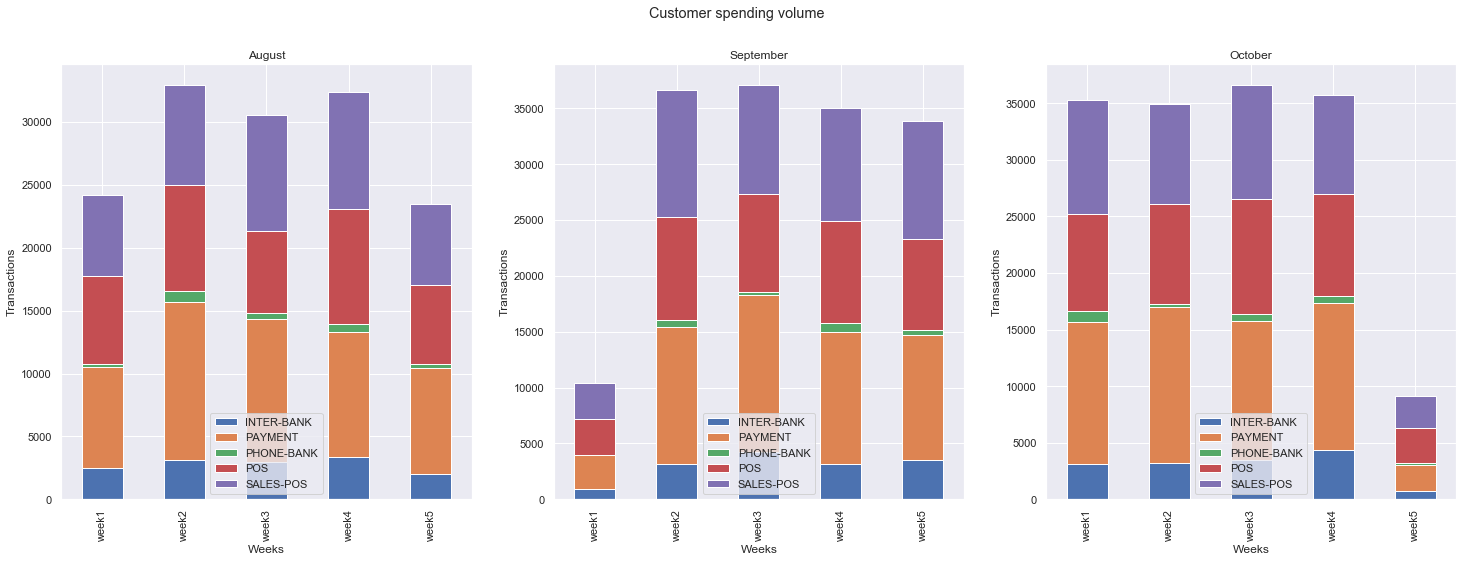

In [202]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Customer spending volume')

aug_spnd_weekly_df.plot(kind='bar', stacked=True, ax = axes[0])

sep_spnd_weekly_df.plot(kind='bar', stacked=True, ax = axes[1])

oct_spnd_weekly_df.plot(kind='bar', stacked=True, ax = axes[2])

axes[0].set(xlabel='Weeks', ylabel='Transactions', title = 'August')
axes[1].set(xlabel='Weeks', ylabel='Transactions', title = 'September')
axes[2].set(xlabel='Weeks', ylabel='Transactions', title = 'October')

axes[0].legend(loc='lower center')
axes[1].legend(loc='lower center')
axes[2].legend(loc='lower center')
plt.show()

# We can visually see that the payment type transactions account for the huge chunk of the weekly expediture.

# Monthly Spending Volume

In [209]:
df_no[(df_no.month == 'Aug') & (df_no.txn_description != 'PAY/SALARY')].groupby('txn_description').amount.sum().values.reshape(1, 5)[0]

array([14034.  , 50255.  ,  2397.  , 37543.86, 39346.76])

In [210]:
spnd_monthly_df = pd.DataFrame(columns = ['INTER-BANK', 'PAYMENT', 'PHONE-BANK', 'POS', 'SALES-POS'],
                                data=[df_no[(df_no.month == 'Aug') & (df_no.txn_description != 'PAY/SALARY')].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     df_no[(df_no.month == 'Sep') & (df_no.txn_description != 'PAY/SALARY')].groupby('txn_description').amount.sum().values.reshape(1, 5)[0],
                                     df_no[(df_no.month == 'Oct') & (df_no.txn_description != 'PAY/SALARY')].groupby('txn_description').amount.sum().values.reshape(1, 5)[0]],
                                index = ['August', 'September', 'October'])

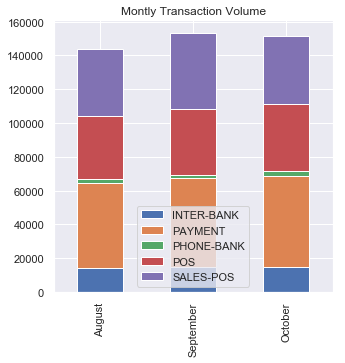

In [211]:
spnd_monthly_df.plot(kind='bar', stacked=True, figsize=(5, 5), title='Montly Transaction Volume')
plt.legend(loc='lower center')

# Hourly Spending Volume

In [266]:
aug_hourly_spnd = df_no[(df_no.month == 'Aug') & (df_no.txn_description != 'PAY/SALARY')].groupby(['hour', 'txn_description']).amount.sum()
sep_hourly_spnd = df_no[(df_no.month == 'Sep') & (df_no.txn_description != 'PAY/SALARY')].groupby(['hour', 'txn_description']).amount.sum()
oct_hourly_spnd = df_no[(df_no.month == 'Oct') & (df_no.txn_description != 'PAY/SALARY')].groupby(['hour', 'txn_description']).amount.sum()

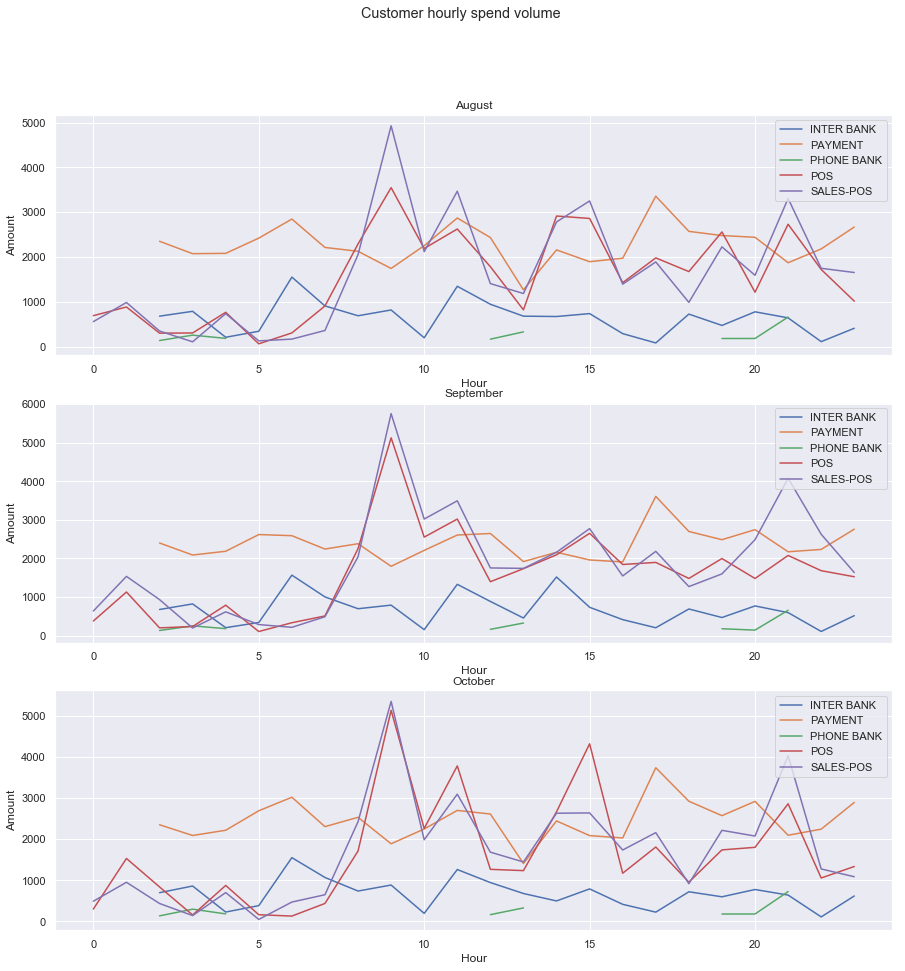

In [270]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle('Customer hourly spend volume')

aug_hourly_spnd.unstack().plot(kind = 'line', ax = axes[0])

sep_hourly_spnd.unstack().plot(kind = 'line', ax = axes[1])

oct_hourly_spnd.unstack().plot(kind = 'line', ax = axes[2])

axes[0].set(xlabel='Hour', ylabel='Amount', title = 'August')
axes[1].set(xlabel='Hour', ylabel='Amount', title = 'September')
axes[2].set(xlabel='Hour', ylabel='Amount', title = 'October')

axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')
plt.show()

# The charts above show customer spending amount during the hours of the day and you can see that they spend the most just before 10 am and peaks again just after 10 pm, and it's mostly POS based transactions

# 5. Insights from location data

We need to apply geocoding to reveal customer longitude and lattitude values but first sort out the dataframe and convert the customer long lat to a proper format

In [36]:
# Create a helper function that would sort out the customer lont lat 

def get_long_lat(long_lat):
    
    pattern = '(\S+)'
    long_lat_list = re.findall(pattern, long_lat)
    
    long = float(long_lat_list[0])
    lat = float(long_lat_list[1])
    
    return long, lat

In [37]:
get_long_lat(df_no.iloc[0].long_lat)

(153.41, -27.95)

So now the longitude and lattitude values are separated

In [38]:
# Put the longitude and lattitude into their own columns and concatenate it with our dataset

long_lat_data = [get_long_lat(x) for x in df_no.long_lat]
long_lat_df = pd.DataFrame(long_lat_data, columns=['customer_longitude', 'customer_lattitude'])
df_no = pd.concat([df_no, long_lat_df], axis = 1)



In [39]:
df_no.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,merchant_long_lat,movement,month,year,hour,minute,seconds,day,customer_longitude,customer_lattitude
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,153.38 -27.99,debit,Aug,2018,01,01,15,1.0,153.41,-27.95
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,151.21 -33.87,debit,Aug,2018,01,13,45,1.0,153.41,-27.95
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,151.21 -33.87,debit,Aug,2018,01,26,15,1.0,151.23,-33.94
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,153.05 -26.68,debit,Aug,2018,01,38,45,1.0,153.10,-27.66
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,153.44 -28.06,debit,Aug,2018,01,51,15,1.0,153.41,-27.95


Get the customer state from the customer longitude and lattitude using geocode.This is a sample below:

In [41]:
string_lat_long = str(df_no.iloc[7,:].customer_lattitude) + ', ' + str(df_no.iloc[7, :].customer_longitude)
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode(string_lat_long)
print(location.raw['display_name'])
location.address

Sheffield Street, Brunswick West, City of Moreland, Victoria, 3055, Australia


'Sheffield Street, Brunswick West, City of Moreland, Victoria, 3055, Australia'

In [42]:
# Create a helper function that would sort out the customer long lat 
def get_address(long_lat):
    
    # Separate the longitude and lattitude first
    pattern = '(\S+)'
    long_lat_list = re.findall(pattern, long_lat)
    
    long = long_lat_list[0]
    lat = long_lat_list[1]
    
    try:
    
        #Get the customer address first
        string_lat_long = lat + ', ' + long
        geolocator = Nominatim(user_agent="specify_your_app_name_here")
        location = geolocator.geocode(string_lat_long)
        address = location.address
        
        return address
    
    except:
        
        return 'Error: ' + long_lat
    

The code block below resolves the longitude and lattitude data into actual addresses. Please don't run it again as it takes around 3 hours to complete.

In [217]:
'''
customer_address = []
for x in df.long_lat:
    address = get_address(x)
    print(address)
    customer_address.append(address)
'''

'\ncustomer_address = []\nfor x in df.long_lat:\n    address = get_address(x)\n    print(address)\n    customer_address.append(address)\n'

Create a new dataframe for the customer address data and attach it into our existing dataframe

In [216]:

# customer_address_df = pd.DataFrame(customer_address, columns=['customer_address'])
# df = pd.concat([df, customer_address_df], axis=1)


It took around 3 hours to resolve all the customer address data from the longitude and lattitude values. I have saved it to a new CSV file.

In [215]:

# df.to_csv(r'C:\Users\john.osorio\Desktop\BLACK CAT\InsideSherpa\ANZ synthesised transaction dataset.csv')


# Reload the udpated df

In [218]:
df = pd.read_csv(r'C:\Users\john.osorio\Desktop\BLACK CAT\InsideSherpa\ANZ synthesised transaction dataset.csv')

In [219]:
df.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [220]:
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,movement,month,day,year,hour,minute,seconds,customer_longitude,customer_lattitude,customer_address
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,debit,Aug,1,2018,1,1,15,153.41,-27.95,"Marine Parade, Labrador, Gold Coast, QLD, 4215..."
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,debit,Aug,1,2018,1,13,45,153.41,-27.95,"Marine Parade, Labrador, Gold Coast, QLD, 4215..."
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,debit,Aug,1,2018,1,26,15,151.23,-33.94,"KFC, Maroubra Road, Maroubra, Bay Gardens, Syd..."
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,debit,Aug,1,2018,1,38,45,153.10,-27.66,"Groves Christian College, Shiraz Court, Marsde..."
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,debit,Aug,1,2018,1,51,15,153.41,-27.95,"Marine Parade, Labrador, Gold Coast, QLD, 4215..."


In [221]:
# regex the address to isolate the state
pattern = 'NSW|VIC|QLD|ACT|TAS|WA|SA|NT|Victoria|New South Wales|Queensland|Western Australia|South Australia|Northern Territory|Australian Capital Territory|Tasmania'
customer_state = []

for x in df.customer_address:
#     print(x)
    reg_address = re.findall(pattern, x)
    if not reg_address:
        customer_state.append('')
    else:
#         print(reg_address[0])
        state = reg_address[0]
        customer_state.append(state)

customer_state_df = pd.DataFrame(customer_state, columns = ['customer_state'])

In [222]:
df = pd.concat([df, customer_state_df], axis = 1)

# Prepare the geographic data to be plotted in Tableau

I have created a new Excel file based on the original ANZ dataset but with the customer address and state and doesn't include PAY/SALARY transactions

In [235]:
aus_spending_data = pd.read_excel(r'C:\Users\john.osorio\Desktop\BLACK CAT\InsideSherpa\ANZ Spending Data.xlsx')

Remove the outliers

In [242]:
anz_spending_data_ver2 = aus_spending_data[aus_spending_data.amount < 523.9]

In [243]:
anz_spending_data_ver2.to_excel(r'C:\Users\john.osorio\Desktop\BLACK CAT\InsideSherpa\ANZ Spending Data Ver 2.xlsx')

The Tableau version of this report can be found below:
https://public.tableau.com/profile/john.osorio#!/vizhome/InsideSherpa_ANZ_EDA/InsideSherpaANZCustomerInsights

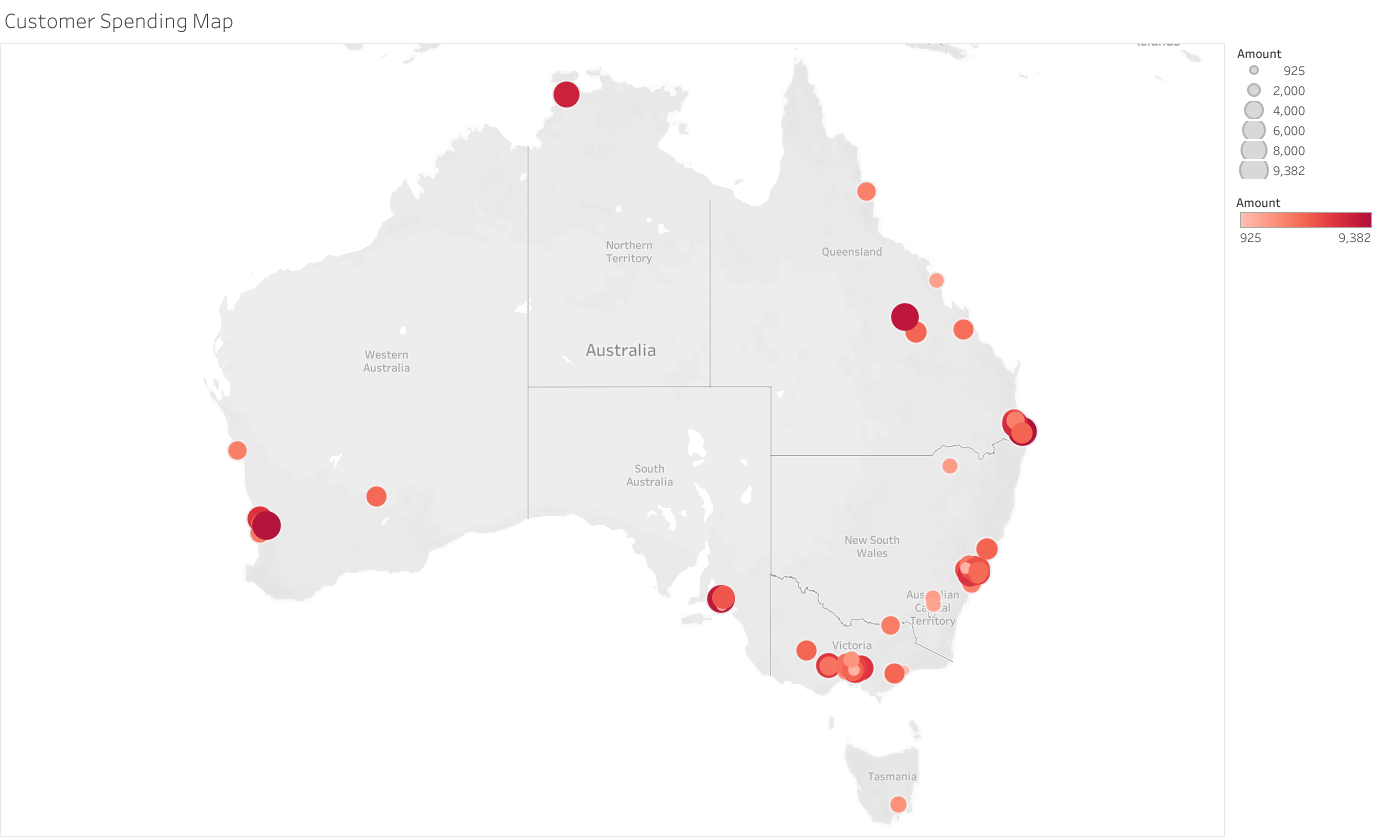

The density map above shows all 100 ANZ Customers (except Daniel since he doesn't have longitude and lattitude data) and the size of their spending. A more interactive version can be found on my Tableau site. 